In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
from imports import *

from sim import multi_sim_run, plot
import time
import os

In [38]:
# prebuilt model classes
import importlib

from models import *
from data import * 
from env import *
from harmonize import *
from metrics import * 
from sim import *


In [48]:
import numpy as np

resolution_vals = [1.000, 1.002] #1.005, 1.02]
# resolution_vals = np.arange(1.0, 1.1, 0.005) # 0.8 1.6

results = {}
for rv in resolution_vals:
    try:
        print(f"Running simulation with resolution {rv}")
    
        start_time = time.time()
        conn_xgb_community_noshared_sim_results = single_sim_run(
            'trans only',
            'community',
            'xgboost',
            use_gpu=True,
            use_shared_regions=False, 
            test_shared_regions=False,
            save_sim=True,
            resolution=rv,
            search_method='bayes',
        )
        end_time = time.time()
        print(f"Simulation took {end_time - start_time} seconds to execute...")
        
        results[rv] = conn_xgb_community_noshared_sim_results
    except Exception as e:
        print(e)
        continue


Running simulation with resolution 1.0
Processing fold 0...
Processing fold 1...
Processing fold 2...

 Test fold num: 1
(6320, 22106) (6320,) (1122, 22106) (1122,)
2
3
Processing fold 0...
Processing fold 1...
ACCELERATING
{'base_estimator': 'GP', 'acq_func': 'PI'}
Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV 1/2] END colsample_bytree=0.8, device=cuda, learning_rate=0.3, max_depth=4, n_estimators=250, random_state=42, reg_alpha=0.01, reg_lambda=0.1, subsample=0.8, tree_method=gpu_hist, verbosity=0;, score=0.618 total time=   1.2s
[CV 2/2] END colsample_bytree=0.8, device=cuda, learning_rate=0.3, max_depth=4, n_estimators=250, random_state=42, reg_alpha=0.01, reg_lambda=0.1, subsample=0.8, tree_method=gpu_hist, verbosity=0;, score=0.525 total time=   1.0s
[CV 1/2] END colsample_bytree=0.8, device=cuda, learning_rate=0.1, max_depth=2, n_estimators=250, random_state=42, reg_alpha=1, reg_lambda=0, subsample=1, tree_method=gpu_hist, verbosity=0;, score=0.663 total time= 

### TRACK CONFIG SIM RUNS FOR RESOLUTION=1.0 (h100 tests)
n_iters=100, n_points=1, n_jobs=1, 'gpu_hist': 868 secs, 15 mins
n_iters=10, n_points=10, n_jobs=1, 'gpu_hist': 23 secs (_this might be what we want_)
n_iters=10, n_points=10, n_jobs=-1, 'gpu_hist': 40 secs (may be getting passed to cpu with n jobs)
n_iters=10, n_points=10, n_jobs=1, 'hist':  23 secs (hist seems to take the same at this level)
n_iters=10, n_points=1, n_jobs=1, 'gpu_hist': 33 secs

n_iters=50, n_points=1, n_jobs=1, 'gpu_hist': ~440 secs, 7 mins
n_iters=10, n_points=5, n_jobs=1, 'gpu_hist': 37 secs
n_iters=1, n_points=50, n_jobs=1, 'gpu_hist':  7 secs


- figure out if gpu_hist or hist is faster... (gpu_hist may be faster for gene expression but hist faster for connectome - size of dataset matters, need to test this)

In [44]:
import pandas as pd

loaded_results = {}

params = [1.000, 1.005] # 1.005, 1.01, 1.015, 1.02, 1.025, 1.1, 1.15, 1.2]
for p in params:
    dataset = f"single_sim_conn_community_xgboost{p}.pickle"
    loaded_results[p] = open_pickled_results(dataset)

filtered_results = []
for r, v in loaded_results.items():
    d = {"resolution": r, "pearson_corr": v[0][0]['test_metrics']['pearson_corr'], "r2": v[0][0]['test_metrics']['r2']}
    filtered_results.append(d)

df = pd.DataFrame.from_dict(filtered_results)
df

,resolution,pearson_corr,r2
0,1.000,0.603874,-1.697643
1,1.005,0.330739,-3.197575


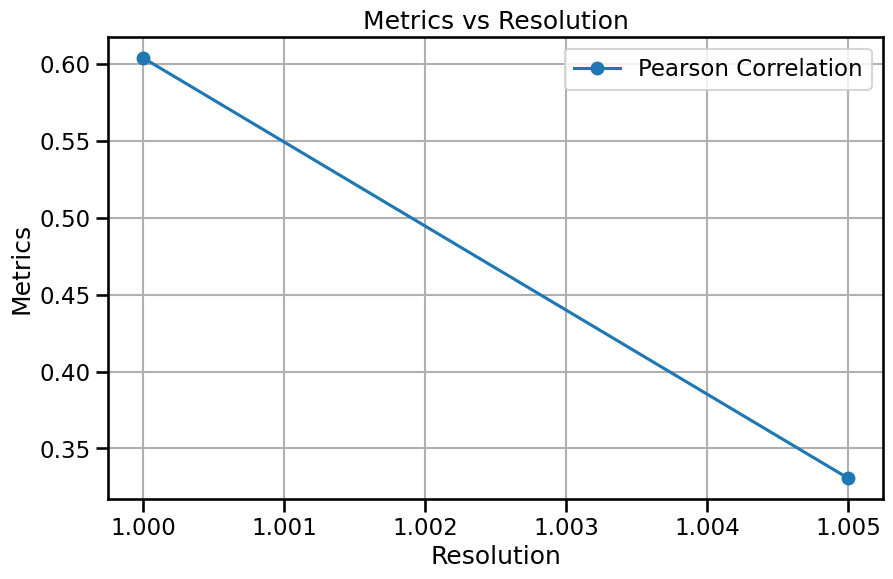

In [45]:
import matplotlib.pyplot as plt

# Plotting pearson_corr
plt.figure(figsize=(10, 6))
plt.plot(df['resolution'], df['pearson_corr'], marker='o', label='Pearson Correlation')
#plt.plot(df['resolution'], df['r2'], marker='o', label='R2')
plt.xlabel('Resolution')
plt.ylabel('Metrics')
plt.title('Metrics vs Resolution')
plt.legend()
plt.grid(True)
plt.show()

In [49]:
plot.plot_predictions(loaded_results[1.002])

KeyError: 1.002